# word2vec 유사도 시각화 

- 코코넛: 박하람, 이육샛별
- 코드 작성자: 박하람(사회학과, 20173666)
- http://blog.daum.net/geoscience/1414 참고


## 1. import modules

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from gensim.models import Word2Vec
from gensim import models
import logging
import datetime
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



## 2. 데이터 불러오기

In [3]:
gender = pd.read_csv('digital-sexual-crime-relevant-bill.csv', index_col=0,
                           parse_dates=['제안일자','의결일자'], encoding='utf-8-sig')
print(gender.shape)
gender.head(3)

(213, 10)


,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,140026,성폭력행위의처벌과피해자보호등에관한법률안,1992-07-22,의원,1993-12-17,대안반영폐기,제14대 (1992~1996) 제157회,"1. 우리 사회의 개방화, 도시화 추세, 그리고 민생치안의 파탄 등으로 여성과 미성...",법제사법위원회,"['박상천', '강창성', '강철선', '강희찬', '국종남', '권노갑', '김대..."
1,152220,아동·청소년의성보호에관한법률안,1999-11-02,의원,1999-11-04,철회,제15대 (1996~2000) 제208회,그 동안 우리사회 일각에서 꾸준히 제기되어 왔던 아동·청소년의 성을 상품화하는 문제...,정무위원회,"['박상천', '박상천', '임채정', '정세균', '김근태', '김길환', '김명..."
2,151088,성폭력범죄의처벌및피해자보호등에관한법률중개정법률안,1998-07-03,의원,1998-12-02,수정가결,제15대 (1996~2000) 제194회,"자기 또는 사람의 성적 욕망을 유발하거나 만족시킬 목적으로 주거·관리하는 건조물, ...",법제사법위원회,"['권영자', '강삼재', '강현욱', '권오을', '김길환', '김영선', '김재..."


In [4]:
gender['제안일자'] = gender['제안일자'].dt.date
gender['의결일자'] = gender['의결일자'].dt.date

## 3. 데이터 전처리

In [5]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '기준','승인','우리','결과','법률안','협의','제출','불구','현재','범위']

    text = [word for word in text if word not in stopwords]
    return text

In [6]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [7]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [8]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 19.5 ms, sys: 1.42 ms, total: 20.9 ms
Wall time: 20.2 ms


In [9]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 30.5 s, sys: 626 ms, total: 31.1 s
Wall time: 17.1 s


0    [성폭력행위의처벌과피해자보호등에관한법률안, 우리, 사회, 개방화, 도시화, 추세, ...
1    [아동, 청소년의성보호에관한법률안, 동안, 우리사회, 일각, 제기, 아동, 청소년,...
2    [성폭력범죄의처벌및피해자보호등에관한법률중개정법률안, 자기, 사람, 성적, 욕망, 유...
Name: tokens, dtype: object

In [10]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 84 ms, sys: 2.07 ms, total: 86 ms
Wall time: 104 ms
CPU times: user 871 µs, sys: 50 µs, total: 921 µs
Wall time: 881 µs


In [11]:
# 정확한 분석을 위해 명사 수가 10개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(213, 13)


## 4. Word2Vec 적용

### 4.1 'N번방' 사건 이전
- 2019년 7월, 'n번방' 사건이 최초 보도되었다.

In [12]:
nth_bf = gender[gender['제안일자'] < datetime.date(2019,7,1)]
nth_bf.shape

(126, 13)

In [13]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [14]:
model_nth_bf = Word2Vec(nth_bf['tokens'], size=100, window = 10, 
                            min_count=10, workers=4, iter=100, sg=1)

2020-12-13 13:56:52,063 : INFO : collecting all words and their counts
2020-12-13 13:56:52,066 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-13 13:56:52,071 : INFO : collected 2322 word types from a corpus of 11411 raw words and 126 sentences
2020-12-13 13:56:52,072 : INFO : Loading a fresh vocabulary
2020-12-13 13:56:52,077 : INFO : effective_min_count=10 retains 194 unique words (8% of original 2322, drops 2128)
2020-12-13 13:56:52,080 : INFO : effective_min_count=10 leaves 6737 word corpus (59% of original 11411, drops 4674)
2020-12-13 13:56:52,085 : INFO : deleting the raw counts dictionary of 2322 items
2020-12-13 13:56:52,088 : INFO : sample=0.001 downsamples 111 most-common words
2020-12-13 13:56:52,089 : INFO : downsampling leaves estimated 3706 word corpus (55.0% of prior 6737)
2020-12-13 13:56:52,092 : INFO : estimated required memory for 194 words and 100 dimensions: 252200 bytes
2020-12-13 13:56:52,096 : INFO : resetting layer weights
20

In [15]:
print(model_nth_bf.wv.most_similar('여성'))
print("-" * 30)
print(model_nth_bf.wv.most_similar('청소년'))
print("-" * 30)
print(model_nth_bf.wv.most_similar('아동'))

2020-12-13 13:56:56,126 : INFO : precomputing L2-norms of word weight vectors


[('벌금형', 0.4130958616733551), ('대상', 0.3717876076698303), ('현실', 0.3598838448524475), ('발전', 0.35279086232185364), ('간음', 0.3443851172924042), ('확산', 0.3131749629974365), ('법정형', 0.3086402416229248), ('성폭력', 0.308163583278656), ('영상물', 0.30143845081329346), ('증가', 0.2922230660915375)]
------------------------------
[('아동', 0.8013885021209717), ('성매매', 0.6608084440231323), ('피해아동', 0.5313078165054321), ('성보호', 0.5291924476623535), ('알선', 0.5025267601013184), ('청소년이용음란물', 0.46900874376296997), ('보호처분', 0.4507162868976593), ('폭행', 0.43763333559036255), ('청소년대상', 0.42735105752944946), ('교육', 0.40892618894577026)]
------------------------------
[('청소년', 0.8013885021209717), ('청소년이용음란물', 0.6878452301025391), ('청소년대상', 0.5694059133529663), ('성매매', 0.5208361148834229), ('제작', 0.5083243250846863), ('성보호', 0.506646454334259), ('대상', 0.5001934766769409), ('알선', 0.4904235005378723), ('성범죄', 0.4712677001953125), ('폭행', 0.40677371621131897)]


In [16]:
df1 = pd.DataFrame(model_nth_bf.wv.most_similar("여성", topn=20), columns=['단어','유사도'])
df2 = pd.DataFrame(model_nth_bf.wv.most_similar("청소년", topn=20), columns=['단어','유사도'])
df3 = pd.DataFrame(model_nth_bf.wv.most_similar("아동", topn=20), columns=['단어','유사도'])

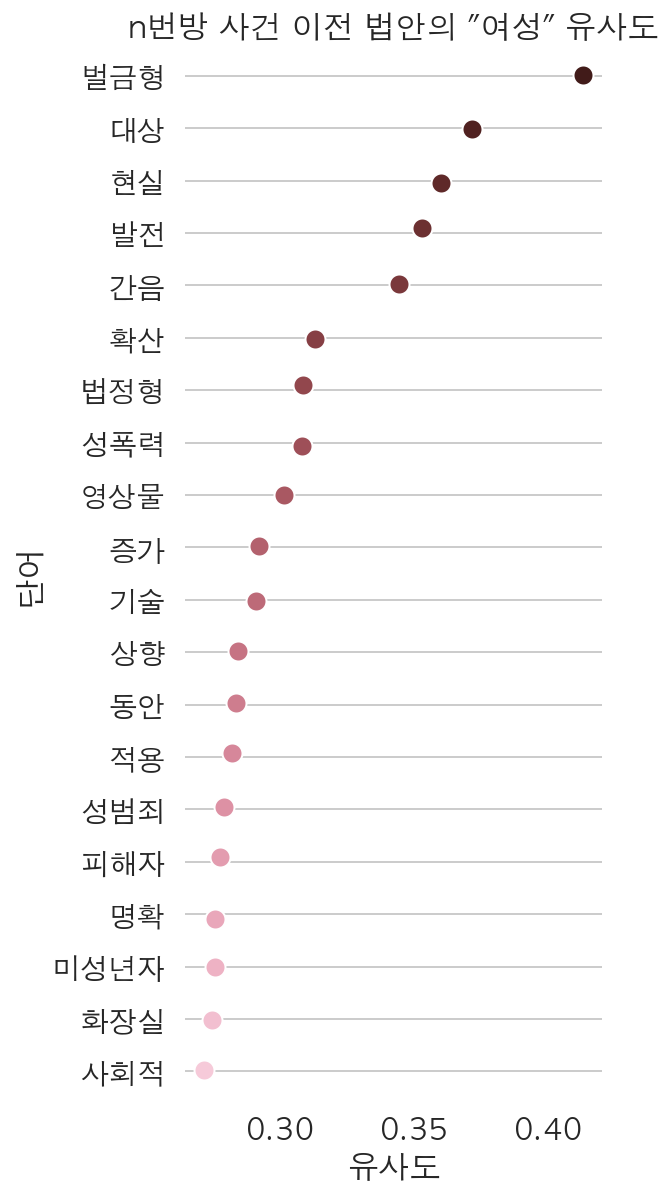

In [19]:
# 여성 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df1, x_vars=df1.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')

titles = df1.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이전 법안의 "여성" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

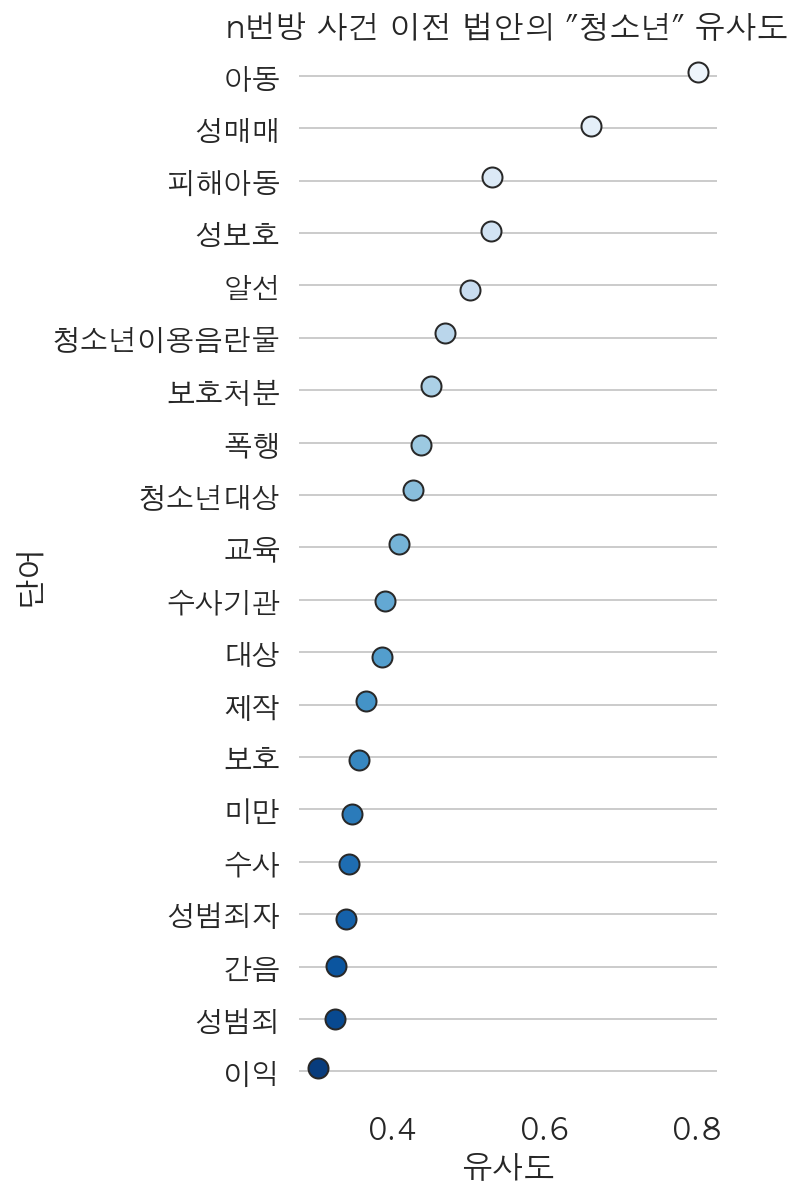

In [20]:
# 청소년 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df2, x_vars=df2.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='Blues', linewidth=1)

titles = df2.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이전 법안의 "청소년" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

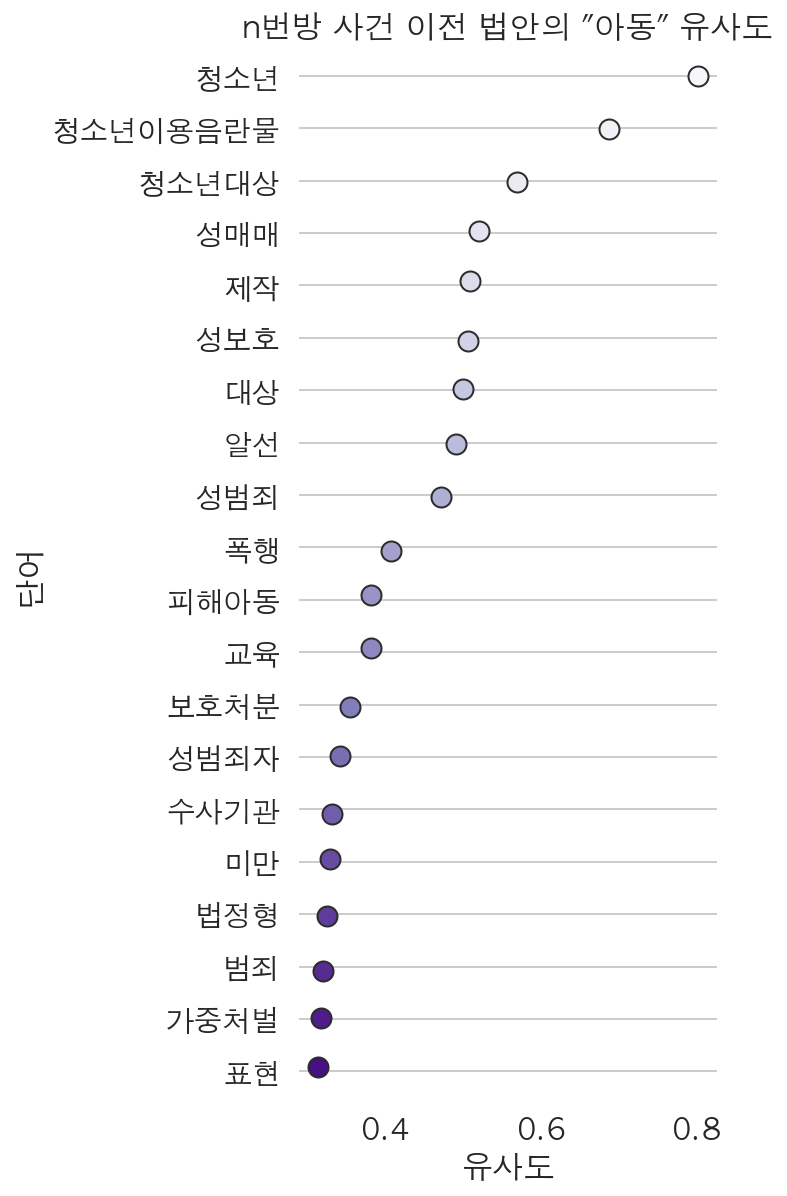

In [21]:
# 아동 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df3, x_vars=df3.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='Purples', linewidth=1)
titles = df3.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이전 법안의 "아동" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

### 4.2 'n번방' 사건 이후

In [22]:
nth_af = gender[gender['제안일자'] >= datetime.date(2019,7,1)]
nth_af.shape

(87, 13)

In [23]:
model_nth_af = Word2Vec(nth_af['tokens'], size=100, window = 10, 
                            min_count=10, workers=4, iter=100, sg=1)

2020-12-13 13:57:58,601 : INFO : collecting all words and their counts
2020-12-13 13:57:58,603 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-13 13:57:58,607 : INFO : collected 1465 word types from a corpus of 6270 raw words and 87 sentences
2020-12-13 13:57:58,608 : INFO : Loading a fresh vocabulary
2020-12-13 13:57:58,611 : INFO : effective_min_count=10 retains 124 unique words (8% of original 1465, drops 1341)
2020-12-13 13:57:58,612 : INFO : effective_min_count=10 leaves 3156 word corpus (50% of original 6270, drops 3114)
2020-12-13 13:57:58,615 : INFO : deleting the raw counts dictionary of 1465 items
2020-12-13 13:57:58,616 : INFO : sample=0.001 downsamples 124 most-common words
2020-12-13 13:57:58,617 : INFO : downsampling leaves estimated 1426 word corpus (45.2% of prior 3156)
2020-12-13 13:57:58,618 : INFO : estimated required memory for 124 words and 100 dimensions: 161200 bytes
2020-12-13 13:57:58,620 : INFO : resetting layer weights
2020-

In [24]:
print(model_nth_af.wv.most_similar('여성'))
print("-" * 30)
print(model_nth_af.wv.most_similar('청소년'))
print("-" * 30)
print(model_nth_af.wv.most_similar('아동'))

2020-12-13 13:58:00,755 : INFO : precomputing L2-norms of word weight vectors


[('공분', 0.5682794451713562), ('성착취', 0.5674268007278442), ('국민적', 0.5640576481819153), ('성착취물', 0.5402790904045105), ('협박', 0.5112999081611633), ('음란물', 0.5099669694900513), ('영상물', 0.49352553486824036), ('유통', 0.48987817764282227), ('텔레그램', 0.4587988257408142), ('정보', 0.42204219102859497)]
------------------------------
[('아동', 0.8250420093536377), ('청소년대상', 0.7388737201690674), ('성보호', 0.6644403338432312), ('청소년성착취물', 0.6090941429138184), ('성착취', 0.5853086709976196), ('청소년이용음란물', 0.5773535370826721), ('공분', 0.5213940143585205), ('변경', 0.4867759943008423), ('경각심', 0.47800520062446594), ('미성년자', 0.47701144218444824)]
------------------------------
[('청소년', 0.8250420689582825), ('청소년이용음란물', 0.7807226777076721), ('청소년대상', 0.7764737606048584), ('청소년성착취물', 0.7693626880645752), ('성보호', 0.7558308839797974), ('변경', 0.6034155488014221), ('경각심', 0.5926497578620911), ('성착취', 0.5913226008415222), ('배포', 0.5501810312271118), ('공분', 0.49083560705184937)]


In [25]:
df1 = pd.DataFrame(model_nth_af.wv.most_similar("여성", topn=20), columns=['단어','유사도'])
df2 = pd.DataFrame(model_nth_af.wv.most_similar("청소년", topn=20), columns=['단어','유사도'])
df3 = pd.DataFrame(model_nth_af.wv.most_similar("아동", topn=20), columns=['단어','유사도'])

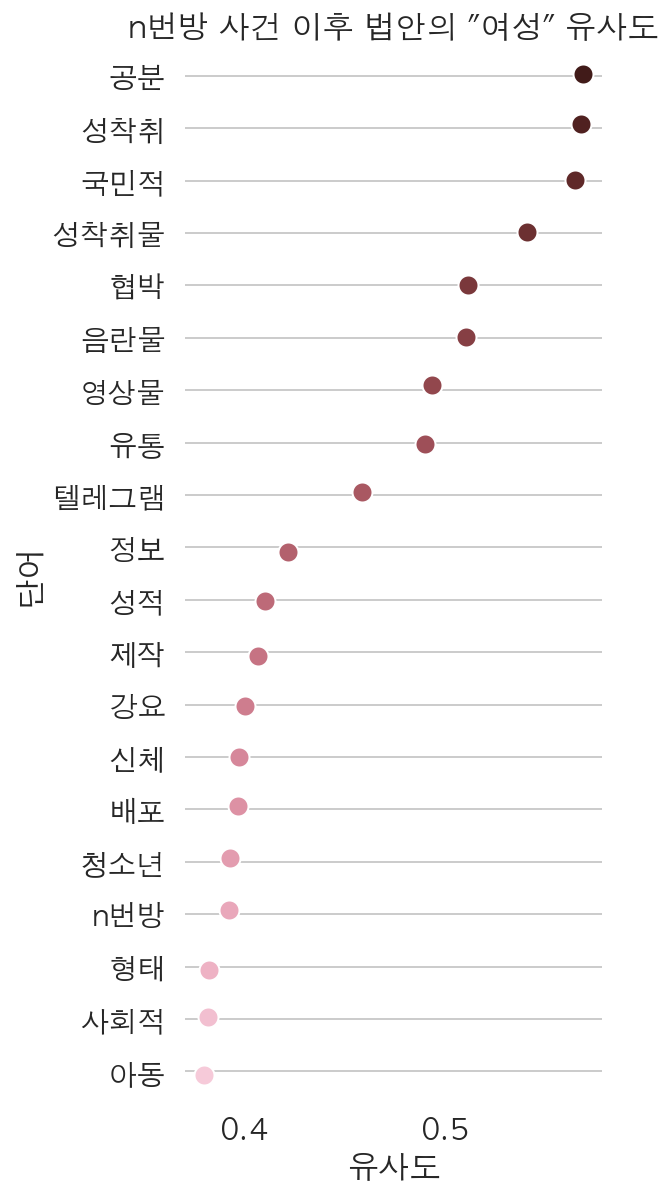

In [26]:
# 여성 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df1, x_vars=df1.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='ch:s=1,r=-.1,h=1_r',
      linewidth=1, edgecolor='w')

titles = df1.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이후 법안의 "여성" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

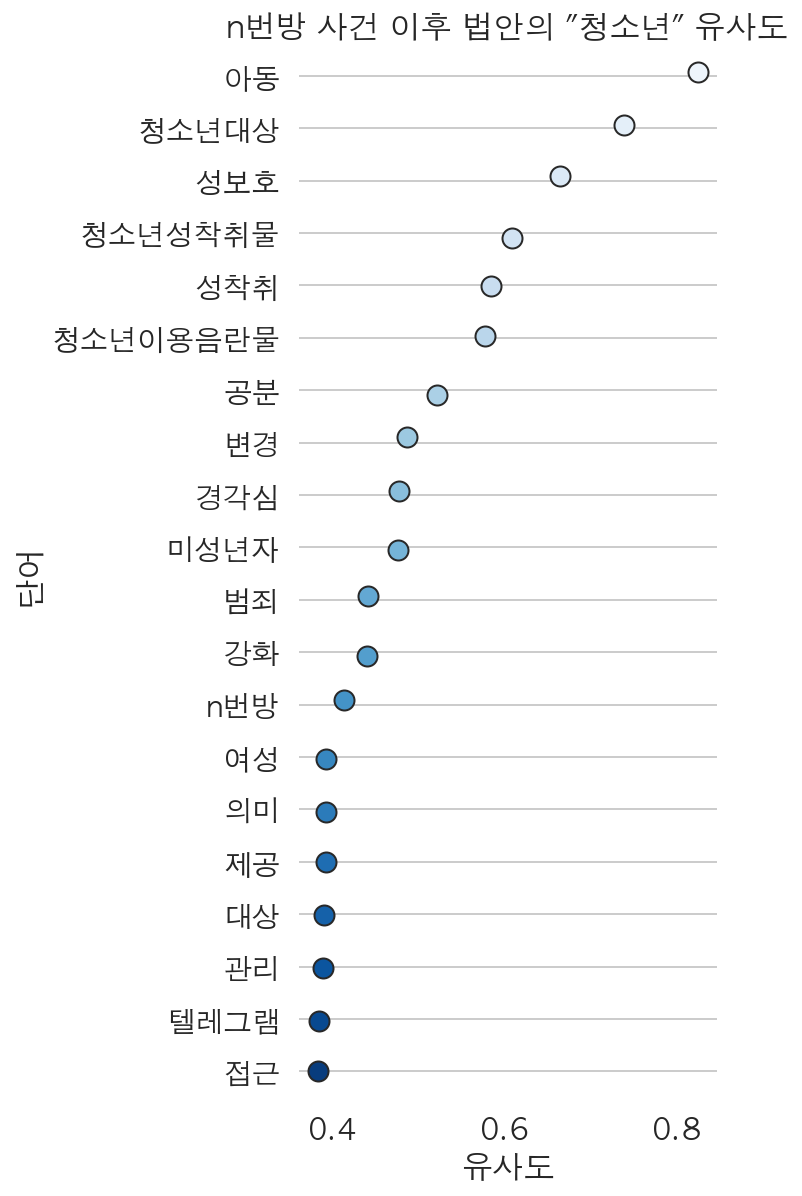

In [27]:
# 청소년 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df2, x_vars=df2.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='Blues', linewidth=1)

titles = df2.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이후 법안의 "청소년" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)

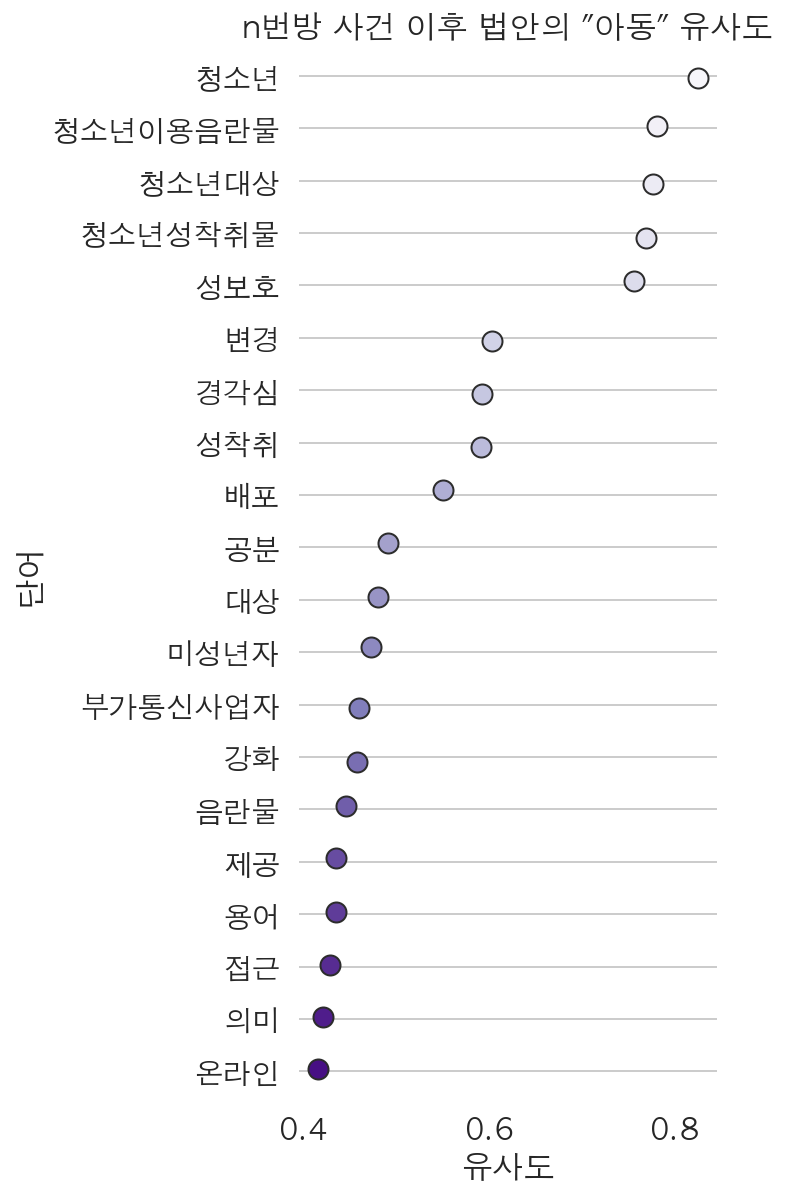

In [28]:
# 아동 유사도 시각화
import seaborn as sns 
sns.set(style='whitegrid', font='AppleGothic', font_scale=1.3)

g = sns.PairGrid(df3, x_vars=df3.columns[1:6], y_vars=['단어'])
g.fig.set_size_inches(5,10)

g.map(sns.stripplot, size=10, orient='h', palette='Purples', linewidth=1)
titles = df3.columns[1:6]

for ax, title in zip(g.axes.flat, titles): 
    ax.set(title='n번방 사건 이후 법안의 "아동" 유사도')
    ax.xaxis.grid(False); ax.yaxis.grid(True)
    
sns.despine(left=True, bottom=True)